In [1]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart
import matplotlib.pyplot as plt
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import run_websocket_server, run_http_server
import tensorflow as tf
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
print(cv2.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Using tf version = 1.15.0
4.1.0


In [12]:
# params 432, 368
w, h = 432, 368
image_path = './data/images/muscle.jpg'
image_path_black = './data/images/muscle_black1.jpg'
model = 'cmu'
resize_out_ratio = 1.0
image = common.read_imgfile(image_path, w, h)
image_black = common.read_imgfile(image_path_black, w, h)

In [4]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_black = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)

In [13]:
# compute with and without 
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
humans_black = e_black.inference(image_black, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

In [6]:
part = humans[0].body_parts[CocoPart.RShoulder.value]
print(f'ORIG: score: {part.score} x: {part.x} y: {part.y} ')
part = humans_black[0].body_parts[CocoPart.RShoulder.value]
print(f'OCCULED: score: {part.score} x: {part.x} y: {part.y} ')

ORIG: score: 0.6426067352294922 x: 0.39814814814814814 y: 0.2608695652173913 
OCCULED: score: 0.5812479853630066 x: 0.39814814814814814 y: 0.2391304347826087 


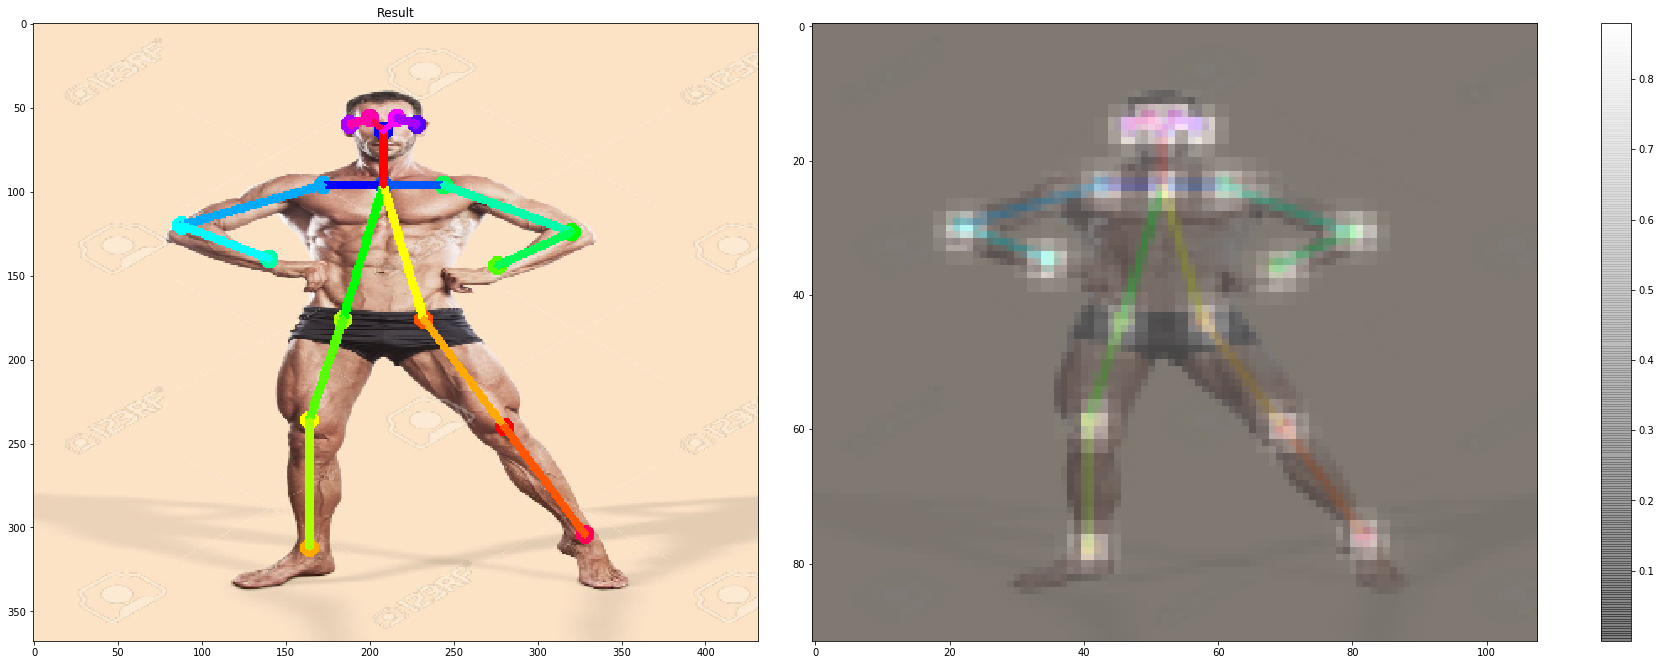

In [7]:
# estimate human poses from a single image !
humans_orig = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
# run again with parameters passed
humans = PoseEstimator.estimate_paf(e.peaks, e.heatMat, e.pafMat)
image_result = TfPoseEstimator.draw_humans(image, humans, imgcopy=True)

fig = plt.figure(figsize=(50, 25))
a = fig.add_subplot(2, 1, 1)
a.set_title('Result')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

bgimg = cv2.cvtColor(image_result.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)

# show network output
a = fig.add_subplot(2, 2, 2)
plt.imshow(bgimg, alpha=0.5)
tmp = np.amax(e.heatMat[:, :, :-1], axis=2)
plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
_ = plt.colorbar()

In [8]:
# find part with smallest score
cur_min = 1.0
part = None
for body_part in humans[0].body_parts.keys():
    if humans[0].body_parts[body_part].score < cur_min:
        part = humans[0].body_parts[body_part]
        cur_min =  humans[0].body_parts[body_part].score

print(part.get_part_name())

CocoPart.RHip


In [ ]:
# REBUILD PEAKS
from tf_pose.tensblur.smoother import Smoother

tensor_heatMat_up = tf.placeholder(dtype=tf.float32, shape=[None, 92, 108, 19], name='alex_test')

smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
gaussian_heatMat = smoother.get_output()

max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(3, 3), pooling_type='MAX', padding='SAME')
tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
tensor_peaks = tf.where(tensor_mask, gaussian_heatMat, tf.zeros_like(gaussian_heatMat))
e.persistent_sess.run(tf.variables_initializer(
            [v for v in tf.global_variables() if
             v.name.split(':')[0] in [x.decode('utf-8') for x in
                                      e.persistent_sess.run(tf.report_uninitialized_variables())]
             ])
        )

[tf_peaks] = e.persistent_sess.run(
    [tensor_peaks],
            feed_dict={
                tensor_heatMat_up: np.expand_dims(e.heatMat, axis=0)
            }
        )
[tf_gaussian_heatMat]= e.persistent_sess.run(
    [gaussian_heatMat],
            feed_dict={
                tensor_heatMat_up: np.expand_dims(e.heatMat, axis=0)
            }
        )
print(e.tensor_heatMat_up.shape)
print(tf_peaks.shape)
print(tensor_mask.shape)
fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(2, 1, 1)

#heat_image = ax.imshow(tf_peaks[0,:,:,CocoPart.RShoulder.value], cmap=plt.cm.hot)
heat_image = ax.imshow(tf_gaussian_heatMat[0,:,:,CocoPart.RShoulder.value], cmap=plt.cm.hot)
ax.set_title('Peaks')

x_ticks = np.arange(0.5, e.peaks.shape[0], 1)
y_ticks = np.arange(0.5, e.peaks.shape[1], 1)

ax.set_xticks(y_ticks)
ax.set_yticks(x_ticks)

ax.grid()
fig.colorbar(heat_image, ax=ax, shrink=1.0)

In [ ]:
print(e.peaks.shape)
# show network output
peaks = np.amax(e.peaks[:, :, :-1], axis=2)
fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(2, 1, 1)

heat_image = ax.imshow(peaks, cmap=plt.cm.hot)
ax.set_title('Peaks')

x_ticks = np.arange(0.5, e.peaks.shape[0], 1)
y_ticks = np.arange(0.5, e.peaks.shape[1], 1)

ax.set_xticks(y_ticks)
ax.set_yticks(x_ticks)

ax.grid()
fig.colorbar(heat_image, ax=ax, shrink=1.0)


In [ ]:
import cv2
tmp= peaks > 0.05
cv2.imwrite("results/plots/muscel_peaks.png", tmp * 255 )

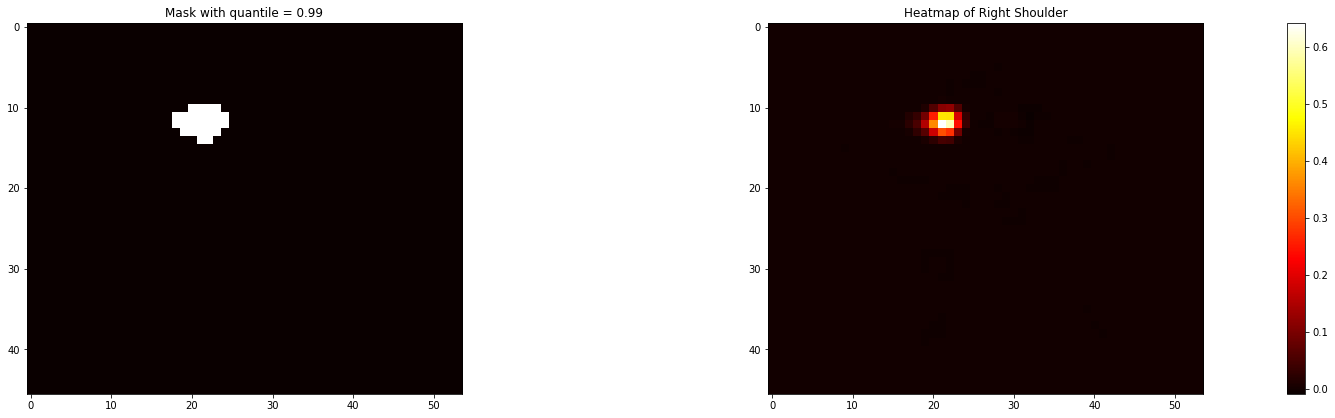

In [16]:
heatmap = e.heatMat[:, :, CocoPart.RShoulder.value]
quantile = 0.99
quant = np.quantile(heatmap, quantile)
mask = heatmap > quant

# show network output
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(2, 1, 1)

heat_image = ax.imshow(heatmap, cmap=plt.cm.hot)
ax.set_title('Heatmap of Right Shoulder')
fig.colorbar(heat_image, ax=ax, shrink=1.0)

ax = fig.add_subplot(2, 2, 1)
ax.set_title(f'Mask with quantile = {quantile}')
ax.imshow(mask, cmap=plt.cm.hot)

In [17]:
x, y = np.unravel_index(heatmap.argmax(), heatmap.shape)
print(f'Max value {heatmap[x, y]} at ({x}, {y})')
print(np.sum(heatmap))
print(e.heatMat.shape, str(type(e.heatMat)))
print(e.pafMat.shape, str(type(e.pafMat)))

print(e.tensor_output.shape, str(type(e.tensor_output)))
print(e.tensor_image.shape, str(type(e.tensor_image)))
print(mask.shape)

Max value 0.6426067352294922 at (12, 21)
5.2387857
(46, 54, 19) <class 'numpy.ndarray'>
(46, 54, 38) <class 'numpy.ndarray'>
(?, ?, ?, 57) <class 'tensorflow.python.framework.ops.Tensor'>
(?, ?, ?, 3) <class 'tensorflow.python.framework.ops.Tensor'>
(46, 54)


In [18]:
# get the current session
sess = e.persistent_sess
#tf.reset_default_graph()
#sess = tf.Session()
LOGDIR = './logs/openPose'

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=e.graph) as de:
    train_writer = tf.summary.FileWriter(LOGDIR)
    train_writer.add_graph(e.graph)
    
    input_tensor = e.tensor_image
    #output_tensor = e.tensor_heatMat[:, x, y, CocoPart.RShoulder.value] # DOES NOT WORK
    output_tensor = e.tensor_heatMat[:, :, :, CocoPart.RShoulder.value]
    xs = tf.expand_dims(image, 0).eval(session=sess)
    xs = xs.astype('float64')
    # print(output_tensor.shape, str(type(output_tensor)))
    # print(input_tensor.shape, str(type(input_tensor)))
    # print(xs.shape, str(type(xs)))
    # Y_shape=[None] + list(xs.shape[1:])
    Y_shape=[None] + [1, 46, 54] # size of heatmaps with resize
    # ys = np.ones([1,] + Y_shape[1:])
    ys = np.expand_dims(np.expand_dims(mask, axis=0), axis=0)
    # print(Y_shape)
    baseline = np.zeros(list(xs.shape)[1:]) # baseline to compare against

    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        #'Integrated Gradients': de.explain('intgrad',  T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        #'Epsilon-LRP':          de.explain('elrp', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        #'DeepLIFT (Rescale)':   de.explain('deeplift', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # takes 4 hours and does not really work 
        #'Occlusion [15x15]':    de.explain('occlusion', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, window_shape=(15,15,3), step=4),
        # not feasable for that size of input
        #'Shapley Sampling':     de.explain('shapley_sampling', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Saliency maps':        de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, ys=ys, Y_shape=Y_shape),
        'Gradient * Input':     de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs, ys=ys, Y_shape=Y_shape),
    }

/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


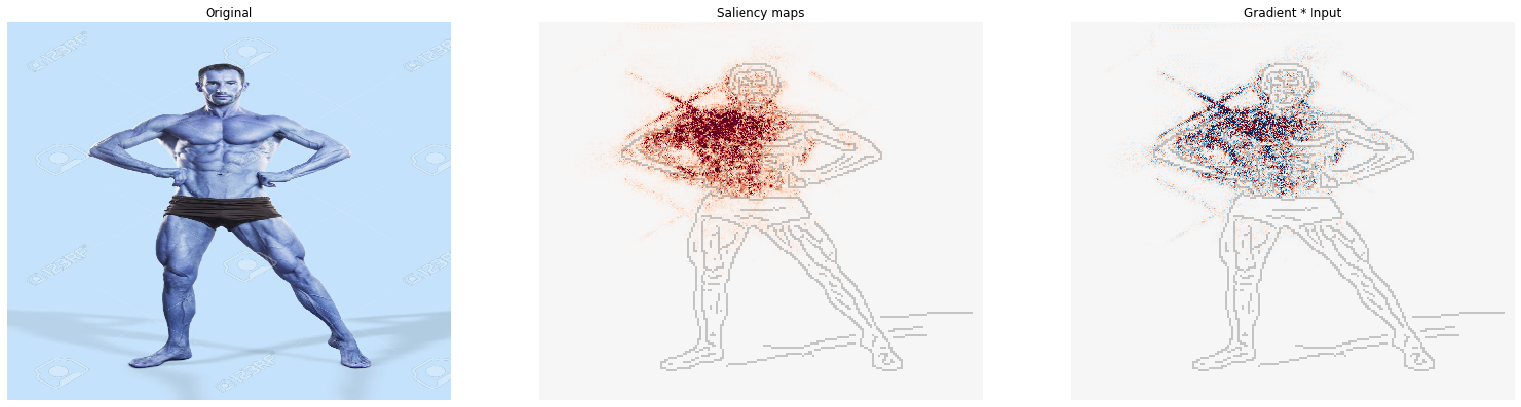

In [19]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs) 
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols*fig_scale, 3*n_rows*fig_scale))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(a)